# Step 1. 실험환경 Set-up

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
import pandas as pd
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
TRAIN_PATH = './data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = './data/val/*/*'
TEST_PATH = './data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE_8 = 8
BATCH_SIZE_16 = 16
BATCH_SIZE_32 = 32


# Step 2. 데이터 준비하기
- augmentation 기법을 고려 (좌우 반전 정도)


In [3]:
# 데이터 파일 재분할
# train, val 데이터 파일 전체에서 분할 (train : val = 8 : 2)
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(f'number of train file : {len(train_filenames)}')
print(f'number of val file : {len(val_filenames)}')

# train 데이터의 정상, 폐렴 데이터 개수
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

# tf.data 선언
# mini-batch로 작업 가능하게 해줌
# 주어진 데이터소스를 여러 Tensor로 짜른다
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

# imgae 개수
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")
VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")


number of train file : 4185
number of val file : 1047
Normal images count in training set: 1072
Pneumonia images count in training set: 3113
Training images count: 4185
Validating images count: 1047


In [4]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

# 데이터 타입 변경 : float32
# 이미지 사이즈 변경 : [180, 180]
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지와 라벨을 읽어옵니다.
# 이미지를 알맞은 형식으로 바꿉니다.
# 데이터 타입, 사이즈
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [5]:
# num_parallel_calls : 병렬 처리 수준 지정
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)


In [6]:
# 데이터 확인
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


Tensorflow에서는 tf.data 파이프라인을 사용해서 학습 데이터를 효율적으로 사용할 수 있도록 해줍니다. 
tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환시켜주겠습니다.

- shuffle()  : 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다.
- repeat()   : 데이터셋의 데이터를 여러번 반복하여 데이터셋 재생성
- batch()    : BATCH_SIZE 크기의 배치 데이터 여러개로 분리
- prefetch() : 첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비, 리소스의 유휴 상태를 줄일 수 있습니다.

In [7]:
# augmentation 기법(좌우 반전)
def augment(image, label):
    image = tf.image.flip_left_right(image)  # 좌우를 반전합니다.
    return image,label


def augment_random(image, label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label


def prepare_for_training(ds, size_batch = BATCH_SIZE_8, state_aug = False ,state_random = False, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    # augment 함수 적용
    if state_aug:
        if state_random:
            ds = ds.map(augment_random, num_parallel_calls=2)
        else:
            ds_aug = ds.map(augment, num_parallel_calls=2)
            ds = ds.concatenate(ds_aug)
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(size_batch)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


In [8]:
train_ds_8 = prepare_for_training(train_ds, BATCH_SIZE_8)
val_ds_8 = prepare_for_training(val_ds, BATCH_SIZE_8)

train_ds_16 = prepare_for_training(train_ds, BATCH_SIZE_16)
val_ds_16 = prepare_for_training(val_ds, BATCH_SIZE_16)

train_ds_32 = prepare_for_training(train_ds, BATCH_SIZE_32)
val_ds_32 = prepare_for_training(val_ds, BATCH_SIZE_32)

#--------------------------------------------------------------------------
train_ds_aug_8 = prepare_for_training(train_ds, BATCH_SIZE_8, True)
val_ds_aug_8 = prepare_for_training(val_ds, BATCH_SIZE_8, True)

train_ds_aug_16 = prepare_for_training(train_ds, BATCH_SIZE_16, True)
val_ds_aug_16 = prepare_for_training(val_ds, BATCH_SIZE_16, True)

train_ds_aug_32 = prepare_for_training(train_ds, BATCH_SIZE_32, True)
val_ds_aug_32 = prepare_for_training(val_ds, BATCH_SIZE_32, True)

#--------------------------------------------------------------------------
train_ds_aug_ran_8 = prepare_for_training(train_ds, BATCH_SIZE_8, True, True)
val_ds_aug_ran_8 = prepare_for_training(val_ds, BATCH_SIZE_8, True, True)

train_ds_aug_ran_16 = prepare_for_training(train_ds, BATCH_SIZE_16, True, True)
val_ds_aug_ran_16 = prepare_for_training(val_ds, BATCH_SIZE_16, True, True)

train_ds_aug_ran_32 = prepare_for_training(train_ds, BATCH_SIZE_32, True, True)
val_ds_aug_ran_32 = prepare_for_training(val_ds, BATCH_SIZE_32, True, True)


____

In [9]:
# test 데이터셋 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()

test_ds_8 = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds_8 = test_ds_8.batch(BATCH_SIZE_8)

test_ds_16 = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds_16 = test_ds_16.batch(BATCH_SIZE_16)

test_ds_32 = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds_32 = test_ds_32.batch(BATCH_SIZE_32)

print(TEST_IMAGE_COUNT)

624


# Step 3. 데이터 시각화

In [10]:
# 데이터 시각화
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch, size_batch = BATCH_SIZE_8):
    plt.figure(figsize=(10,10))
    for n in range(size_batch):
        ax = plt.subplot(4,math.ceil(size_batch/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

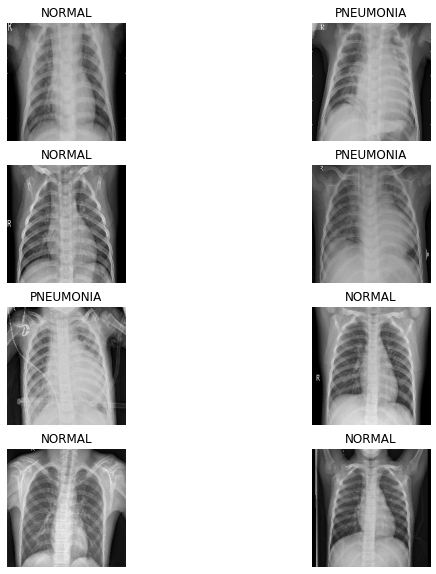

In [11]:
image_batch, label_batch = next(iter(test_ds_8))
show_batch(image_batch.numpy(), label_batch.numpy())

# Step 4. CNN 모델링

In [12]:
# conv block
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])    
    return block

# dense block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block


In [13]:
# model build
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


# Step 5. 데이터 imbalance 처리

In [14]:
# weight는 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# Step 6. 모델 훈련

In [15]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [16]:
history = []
model_ = []

### fit
- 첫 인자: 훈련데이터셋을 제공할 제네레이터를 지정합니다. 본 예제에서는 앞서 생성한 train_generator으로 지정합니다.
- steps_per_epoch : 한 epoch에 사용한 스텝 수를 지정합니다. 총 45개의 훈련 샘플이 있고 배치사이즈가 3이므로 15 스텝으로 지정합니다.
- epochs : 전체 훈련 데이터셋에 대해 학습 반복 횟수를 지정합니다. 100번을 반복적으로 학습시켜 보겠습니다.
- validation_data : 검증데이터셋을 제공할 제네레이터를 지정합니다. 본 예제에서는 앞서 생성한 validation_generator으로 지정합니다.
- validation_steps : 한 epoch 종료 시 마다 검증할 때 사용되는 검증 스텝 수를 지정합니다. 홍 15개의 검증 샘플이 있고 배치사이즈가 3이므로 5 스텝으로 지정합니다.

In [17]:
# 결과 확인
def show_result(history_, test_ds_):
    fig, ax = plt.subplots(1, 4, figsize=(20, 3))
    ax = ax.ravel()
    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history_.history[met])
        ax[i].plot(history_.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
    plt.show()

    # 평가
    loss, accuracy, precision, recall = model.evaluate(test_ds_)
    print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

___

Epoch 1/5
130/130 [==============================] - 60s 367ms/step - loss: 0.4306 - accuracy: 0.8250 - precision: 0.9375 - recall: 0.8194 - val_loss: 0.7060 - val_accuracy: 0.7383 - val_precision: 0.7383 - val_recall: 1.0000
Epoch 2/5
130/130 [==============================] - 48s 367ms/step - loss: 0.1730 - accuracy: 0.9450 - precision: 0.9668 - recall: 0.9589 - val_loss: 1.0172 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 3/5
130/130 [==============================] - 48s 371ms/step - loss: 0.1600 - accuracy: 0.9457 - precision: 0.9653 - recall: 0.9616 - val_loss: 1.1023 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 4/5
130/130 [==============================] - 48s 373ms/step - loss: 0.1435 - accuracy: 0.9541 - precision: 0.9675 - recall: 0.9709 - val_loss: 1.2742 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 5/5
130/130 [==============================] - 50s 383ms/step - loss: 0.1259 - accuracy: 0

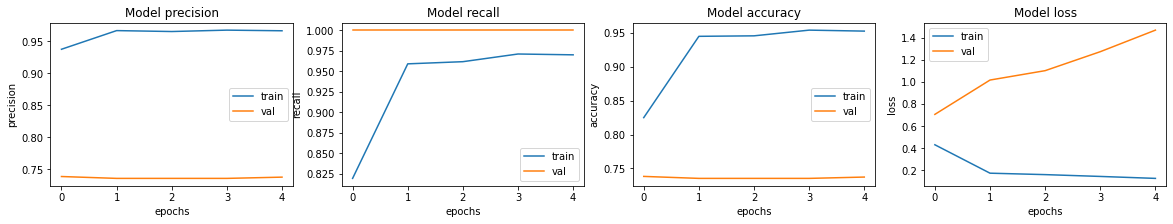

20/20 [==============================] - 5s 232ms/step - loss: 2.1942 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 2.194167375564575,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


In [18]:
EPOCHS = 5
with tf.device('/GPU:0'):
    buf_history = model.fit(
        train_ds_32,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_32,
        epochs=EPOCHS,
        validation_data=val_ds_32,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_32,
    )
model_.append(model)
history.append(buf_history)   
# 결과 확인
show_result(buf_history, test_ds_32)


In [19]:
history = []
model_ = []

# test 1 (epoch)
- epoch : 5 / 10 / 15
- batch size : 32
- augmentation : x
- class_weight : x


- epoch를 5, 10, 15로 학습하였을때 결과의 차이가 유의미해 보이지 않음
- epoch 5로 다른 학습 진행

In [20]:
EPOCHS = 5
buf_history = None
with tf.device('/GPU:0'):
    buf_history = model.fit(
        train_ds_32,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_32,
        epochs=EPOCHS,
        validation_data=val_ds_32,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_32,
    )
model_.append(model)
history.append(buf_history)   

Epoch 1/5
130/130 [==============================] - 55s 363ms/step - loss: 0.1049 - accuracy: 0.9613 - precision: 0.9723 - recall: 0.9758 - val_loss: 0.4781 - val_accuracy: 0.8105 - val_precision: 0.7945 - val_recall: 1.0000
Epoch 2/5
130/130 [==============================] - 48s 368ms/step - loss: 0.1013 - accuracy: 0.9644 - precision: 0.9749 - recall: 0.9774 - val_loss: 0.5029 - val_accuracy: 0.8691 - val_precision: 1.0000 - val_recall: 0.8218
Epoch 3/5
130/130 [==============================] - 48s 368ms/step - loss: 0.0883 - accuracy: 0.9702 - precision: 0.9800 - recall: 0.9800 - val_loss: 0.3991 - val_accuracy: 0.8135 - val_precision: 0.7987 - val_recall: 0.9987
Epoch 4/5
130/130 [==============================] - 48s 371ms/step - loss: 0.0889 - accuracy: 0.9700 - precision: 0.9777 - recall: 0.9819 - val_loss: 0.0919 - val_accuracy: 0.9697 - val_precision: 0.9891 - val_recall: 0.9693
Epoch 5/5
130/130 [==============================] - 50s 383ms/step - loss: 0.0727 - accuracy: 0

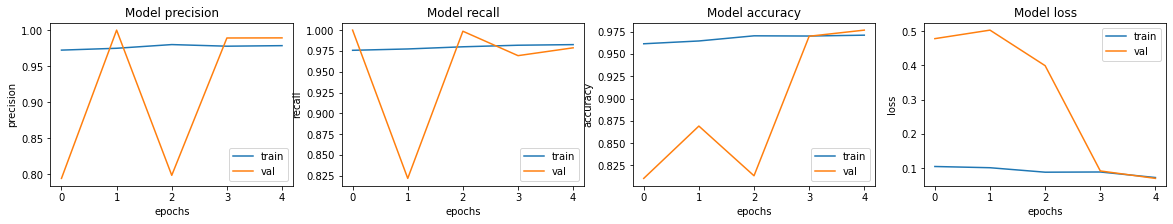

20/20 [==============================] - 4s 212ms/step - loss: 0.7852 - accuracy: 0.7548 - precision: 0.7215 - recall: 0.9897
Loss: 0.7852072715759277,
Accuracy: 0.754807710647583,
Precision: 0.7214953303337097,
Recall: 0.9897435903549194


In [21]:
# 결과 확인
show_result(buf_history, test_ds_32)


In [22]:
EPOCHS = 10
buf_history = None
with tf.device('/GPU:0'):
    buf_history = model.fit(
        train_ds_32,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_32,
        epochs=EPOCHS,
        validation_data=val_ds_32,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_32,
    )
model_.append(model)
history.append(buf_history)   

Epoch 1/10
130/130 [==============================] - 54s 363ms/step - loss: 0.0798 - accuracy: 0.9707 - precision: 0.9800 - recall: 0.9806 - val_loss: 0.7955 - val_accuracy: 0.7549 - val_precision: 0.7510 - val_recall: 1.0000
Epoch 2/10
130/130 [==============================] - 47s 366ms/step - loss: 0.0737 - accuracy: 0.9731 - precision: 0.9813 - recall: 0.9826 - val_loss: 0.0587 - val_accuracy: 0.9834 - val_precision: 0.9906 - val_recall: 0.9867
Epoch 3/10
130/130 [==============================] - 48s 370ms/step - loss: 0.0753 - accuracy: 0.9707 - precision: 0.9774 - recall: 0.9831 - val_loss: 0.0749 - val_accuracy: 0.9746 - val_precision: 0.9853 - val_recall: 0.9800
Epoch 4/10
130/130 [==============================] - 49s 377ms/step - loss: 0.0684 - accuracy: 0.9755 - precision: 0.9823 - recall: 0.9849 - val_loss: 0.0928 - val_accuracy: 0.9697 - val_precision: 0.9918 - val_recall: 0.9668
Epoch 5/10
130/130 [==============================] - 50s 385ms/step - loss: 0.0693 - accura

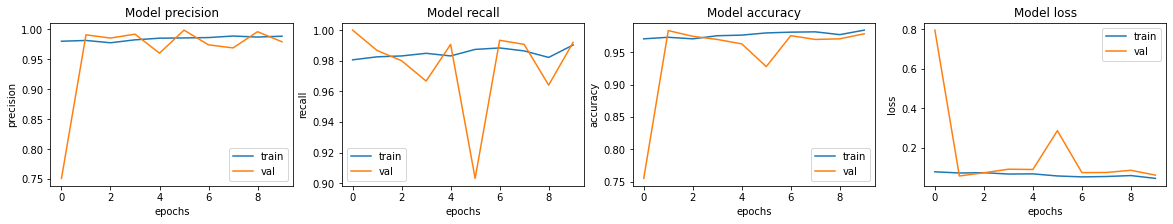

20/20 [==============================] - 4s 193ms/step - loss: 1.4144 - accuracy: 0.7131 - precision: 0.6867 - recall: 0.9949
Loss: 1.4144338369369507,
Accuracy: 0.7131410241127014,
Precision: 0.6867256760597229,
Recall: 0.9948717951774597


In [23]:
# 결과 확인
show_result(buf_history, test_ds_32)


In [24]:
EPOCHS = 15
buf_history = None
with tf.device('/GPU:0'):
    buf_history = model.fit(
        train_ds_32,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_32,
        epochs=EPOCHS,
        validation_data=val_ds_32,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_32,
    )
model_.append(model)
history.append(buf_history)   

Epoch 1/15
130/130 [==============================] - 54s 364ms/step - loss: 0.0586 - accuracy: 0.9825 - precision: 0.9887 - recall: 0.9877 - val_loss: 0.0579 - val_accuracy: 0.9805 - val_precision: 0.9894 - val_recall: 0.9841
Epoch 2/15
130/130 [==============================] - 48s 368ms/step - loss: 0.0574 - accuracy: 0.9788 - precision: 0.9867 - recall: 0.9848 - val_loss: 0.0839 - val_accuracy: 0.9697 - val_precision: 0.9891 - val_recall: 0.9694
Epoch 3/15
130/130 [==============================] - 48s 372ms/step - loss: 0.0434 - accuracy: 0.9851 - precision: 0.9906 - recall: 0.9894 - val_loss: 0.0929 - val_accuracy: 0.9697 - val_precision: 0.9627 - val_recall: 0.9973
Epoch 4/15
130/130 [==============================] - 49s 379ms/step - loss: 0.0248 - accuracy: 0.9916 - precision: 0.9938 - recall: 0.9948 - val_loss: 0.0726 - val_accuracy: 0.9785 - val_precision: 0.9933 - val_recall: 0.9775
Epoch 5/15
130/130 [==============================] - 50s 390ms/step - loss: 0.0248 - accura

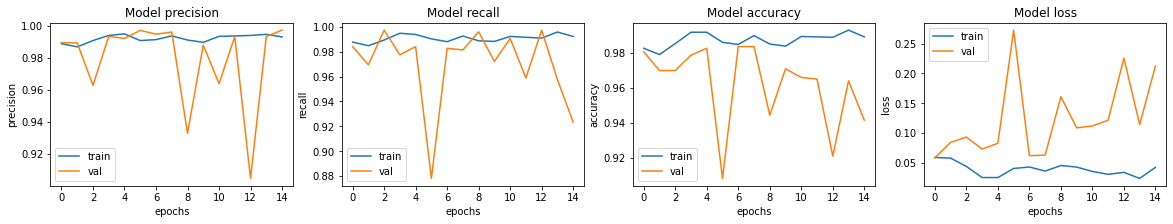

20/20 [==============================] - 4s 205ms/step - loss: 0.7655 - accuracy: 0.8542 - precision: 0.8345 - recall: 0.9564
Loss: 0.7655445337295532,
Accuracy: 0.8541666865348816,
Precision: 0.8344519138336182,
Recall: 0.9564102292060852


In [25]:
# 결과 확인
show_result(buf_history, test_ds_32)


# test 2 (batch size)
- epoch : 5
- batch size : 8 / 16 / 32
- augmentation : x
- class_weight : x


- batch size 8, 16, 32로 테스트
- 32 일때 안정적인 것으로 보임

In [26]:
EPOCHS = 5
buf_history = None
with tf.device('/GPU:0'):
    buf_history = model.fit(
        train_ds_8,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_8,
        epochs=EPOCHS,
        validation_data=val_ds_8,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_8,
    )
model_.append(model)
history.append(buf_history)   

Epoch 1/5
523/523 [==============================] - 57s 94ms/step - loss: 0.2457 - accuracy: 0.9116 - precision: 0.9451 - recall: 0.9354 - val_loss: 0.1124 - val_accuracy: 0.9558 - val_precision: 0.9567 - val_recall: 0.9843
Epoch 2/5
523/523 [==============================] - 49s 94ms/step - loss: 0.2358 - accuracy: 0.9092 - precision: 0.9432 - recall: 0.9341 - val_loss: 0.1152 - val_accuracy: 0.9548 - val_precision: 0.9905 - val_recall: 0.9478
Epoch 3/5
523/523 [==============================] - 49s 94ms/step - loss: 0.1986 - accuracy: 0.9204 - precision: 0.9525 - recall: 0.9399 - val_loss: 0.1383 - val_accuracy: 0.9490 - val_precision: 0.9449 - val_recall: 0.9882
Epoch 4/5
523/523 [==============================] - 50s 95ms/step - loss: 0.1797 - accuracy: 0.9321 - precision: 0.9591 - recall: 0.9492 - val_loss: 0.1073 - val_accuracy: 0.9606 - val_precision: 0.9714 - val_recall: 0.9752
Epoch 5/5
523/523 [==============================] - 50s 97ms/step - loss: 0.1681 - accuracy: 0.9357

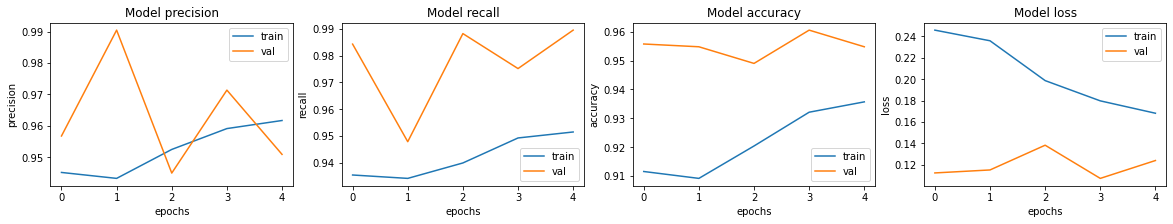

78/78 [==============================] - 4s 55ms/step - loss: 0.9880 - accuracy: 0.7147 - precision: 0.6879 - recall: 0.9949
Loss: 0.98795485496521,
Accuracy: 0.7147436141967773,
Precision: 0.6879432797431946,
Recall: 0.9948717951774597


In [27]:
# 결과 확인
show_result(buf_history, test_ds_8)


In [28]:
with tf.device('/GPU:0'):
    buf_history = model.fit(
        train_ds_16,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_16,
        epochs=EPOCHS,
        validation_data=val_ds_16,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_16,
    )
model_.append(model)
history.append(buf_history)   

Epoch 1/5
261/261 [==============================] - 57s 188ms/step - loss: 0.1033 - accuracy: 0.9646 - precision: 0.9771 - recall: 0.9752 - val_loss: 0.1424 - val_accuracy: 0.9423 - val_precision: 0.9293 - val_recall: 0.9974
Epoch 2/5
261/261 [==============================] - 49s 187ms/step - loss: 0.0765 - accuracy: 0.9753 - precision: 0.9855 - recall: 0.9813 - val_loss: 0.0567 - val_accuracy: 0.9846 - val_precision: 0.9895 - val_recall: 0.9895
Epoch 3/5
261/261 [==============================] - 49s 189ms/step - loss: 0.0687 - accuracy: 0.9784 - precision: 0.9874 - recall: 0.9836 - val_loss: 0.0558 - val_accuracy: 0.9808 - val_precision: 0.9882 - val_recall: 0.9856
Epoch 4/5
261/261 [==============================] - 49s 189ms/step - loss: 0.0665 - accuracy: 0.9775 - precision: 0.9864 - recall: 0.9832 - val_loss: 0.0747 - val_accuracy: 0.9731 - val_precision: 0.9946 - val_recall: 0.9686
Epoch 5/5
261/261 [==============================] - 50s 191ms/step - loss: 0.0518 - accuracy: 0

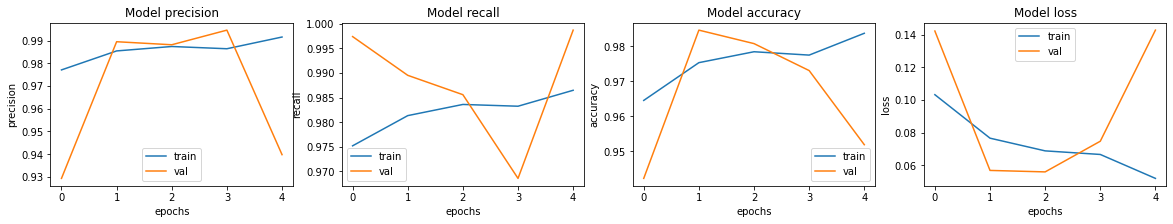

39/39 [==============================] - 4s 111ms/step - loss: 1.5622 - accuracy: 0.6747 - precision: 0.6577 - recall: 1.0000
Loss: 1.562209963798523,
Accuracy: 0.6746794581413269,
Precision: 0.6576728224754333,
Recall: 1.0


In [29]:
# 결과 확인
show_result(buf_history, test_ds_16)


In [30]:
with tf.device('/GPU:0'):
    buf_history = model.fit(
        train_ds_32,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_32,
        epochs=EPOCHS,
        validation_data=val_ds_32,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_32,
    )
model_.append(model)
history.append(buf_history)   

Epoch 1/5
130/130 [==============================] - 55s 365ms/step - loss: 0.0328 - accuracy: 0.9897 - precision: 0.9939 - recall: 0.9922 - val_loss: 0.0535 - val_accuracy: 0.9863 - val_precision: 0.9907 - val_recall: 0.9907
Epoch 2/5
130/130 [==============================] - 47s 366ms/step - loss: 0.0200 - accuracy: 0.9945 - precision: 0.9971 - recall: 0.9955 - val_loss: 0.0619 - val_accuracy: 0.9805 - val_precision: 0.9854 - val_recall: 0.9880
Epoch 3/5
130/130 [==============================] - 48s 368ms/step - loss: 0.0239 - accuracy: 0.9952 - precision: 0.9968 - recall: 0.9968 - val_loss: 0.0566 - val_accuracy: 0.9824 - val_precision: 0.9920 - val_recall: 0.9841
Epoch 4/5
130/130 [==============================] - 48s 372ms/step - loss: 0.0137 - accuracy: 0.9947 - precision: 0.9971 - recall: 0.9958 - val_loss: 0.0620 - val_accuracy: 0.9785 - val_precision: 0.9946 - val_recall: 0.9762
Epoch 5/5
130/130 [==============================] - 50s 383ms/step - loss: 0.0085 - accuracy: 0

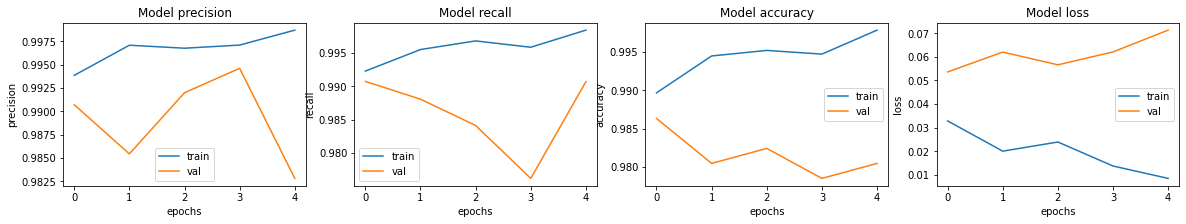

20/20 [==============================] - 4s 210ms/step - loss: 1.8033 - accuracy: 0.7228 - precision: 0.6927 - recall: 1.0000
Loss: 1.8033218383789062,
Accuracy: 0.7227563858032227,
Precision: 0.6927176117897034,
Recall: 1.0


In [31]:
# 결과 확인
show_result(buf_history, test_ds_32)


# test 3 (augmentation)
- epoch : 5
- batch size : 32
- augmentation : X, O, O_random
- class_weight : x


- augmentation 좌우 반전 사용
    - x : data set 그대로 사용
    - O : data set 원본 + data set 좌우 반전 (data set 양 2배)
    - O_random : data set 원본에서 일부 data만 반전
- augmentation의 결과로 추가 생성되는 data set에 따라 결과의 변동이 있음 

- O_random 데이터에 weight를 적용하니까 학습 결과가 고정 되는 경우가 있음
    - Loss: 2.2209930419921875
    - Accuracy: 0.625
    - Precision: 0.625
    - Recall: 1.0

- 왜?
    - pneumoniad 데이터가 많음, normal 데이터가 작음
    - normal 데이터가 작기때문에 랜덤 augmentation의 영향을 상대적으로 크게 받음
    - 둘중하나, normal을 잘 구별하는 경우 
    - normal 예측을 안하는 경우 (weight로 loss에 영향을 크게 주고 학습에 문제가 생김)
        - 변경된 normal 데이터를 모두 pneumoniad로 예측
        - FN 낮아짐(=0) recall 커짐(=1)
        - FP 커짐 Precision 작아짐
        - pneumoniad의 데이터가 많기 때문에 일정 이하로 안떨어지는가? (0.625)


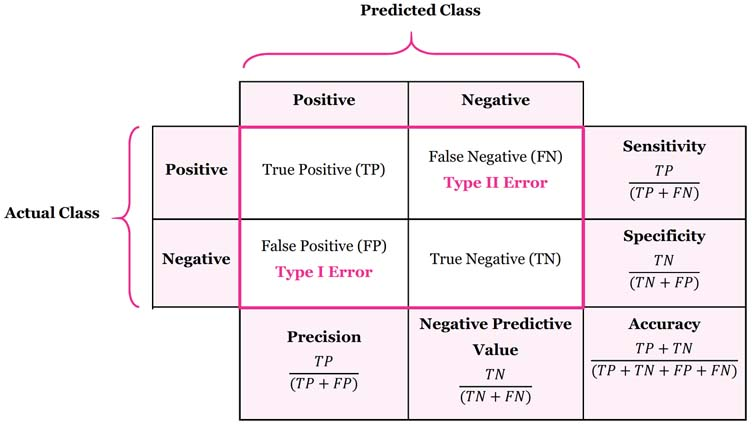

Epoch 1/5
130/130 [==============================] - 54s 362ms/step - loss: 0.0085 - accuracy: 0.9978 - precision: 0.9984 - recall: 0.9987 - val_loss: 0.0848 - val_accuracy: 0.9795 - val_precision: 0.9933 - val_recall: 0.9788
Epoch 2/5
130/130 [==============================] - 48s 367ms/step - loss: 0.0095 - accuracy: 0.9962 - precision: 0.9977 - recall: 0.9971 - val_loss: 0.0780 - val_accuracy: 0.9746 - val_precision: 0.9946 - val_recall: 0.9708
Epoch 3/5
130/130 [==============================] - 48s 371ms/step - loss: 0.0067 - accuracy: 0.9978 - precision: 0.9984 - recall: 0.9987 - val_loss: 0.0665 - val_accuracy: 0.9824 - val_precision: 0.9933 - val_recall: 0.9828
Epoch 4/5
130/130 [==============================] - 48s 372ms/step - loss: 0.0029 - accuracy: 0.9995 - precision: 1.0000 - recall: 0.9994 - val_loss: 0.0786 - val_accuracy: 0.9824 - val_precision: 0.9907 - val_recall: 0.9854
Epoch 5/5
130/130 [==============================] - 49s 381ms/step - loss: 0.0080 - accuracy: 0

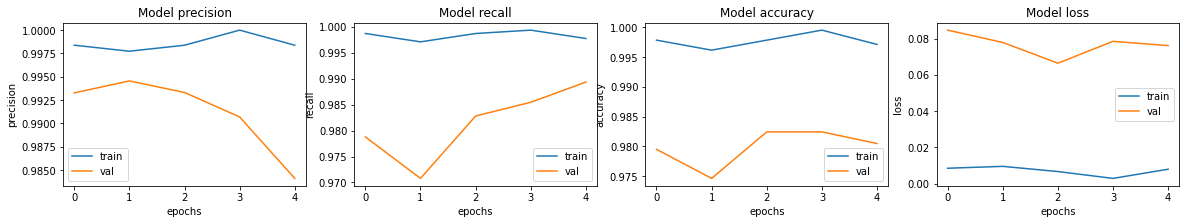

20/20 [==============================] - 4s 218ms/step - loss: 2.5572 - accuracy: 0.7179 - precision: 0.6897 - recall: 0.9974
Loss: 2.557206153869629,
Accuracy: 0.7179487347602844,
Precision: 0.6897163391113281,
Recall: 0.9974358677864075


In [37]:
EPOCHS = 5
with tf.device('/GPU:0'):
    buf_history = model.fit(
        train_ds_32,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_32,
        epochs=EPOCHS,
        validation_data=val_ds_32,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_32,
    )
model_.append(model)
history.append(buf_history)   
# 결과 확인
show_result(buf_history, test_ds_32)


Epoch 1/5
130/130 [==============================] - 56s 374ms/step - loss: 0.0259 - accuracy: 0.9913 - precision: 0.9942 - recall: 0.9942 - val_loss: 0.1041 - val_accuracy: 0.9727 - val_precision: 0.9853 - val_recall: 0.9775
Epoch 2/5
130/130 [==============================] - 48s 371ms/step - loss: 0.0386 - accuracy: 0.9875 - precision: 0.9929 - recall: 0.9903 - val_loss: 0.0782 - val_accuracy: 0.9775 - val_precision: 0.9959 - val_recall: 0.9730
Epoch 3/5
130/130 [==============================] - 49s 375ms/step - loss: 0.0129 - accuracy: 0.9954 - precision: 0.9974 - recall: 0.9964 - val_loss: 0.0799 - val_accuracy: 0.9766 - val_precision: 0.9743 - val_recall: 0.9948
Epoch 4/5
130/130 [==============================] - 48s 373ms/step - loss: 0.0266 - accuracy: 0.9892 - precision: 0.9929 - recall: 0.9926 - val_loss: 0.0793 - val_accuracy: 0.9766 - val_precision: 0.9933 - val_recall: 0.9749
Epoch 5/5
130/130 [==============================] - 50s 387ms/step - loss: 0.0123 - accuracy: 0

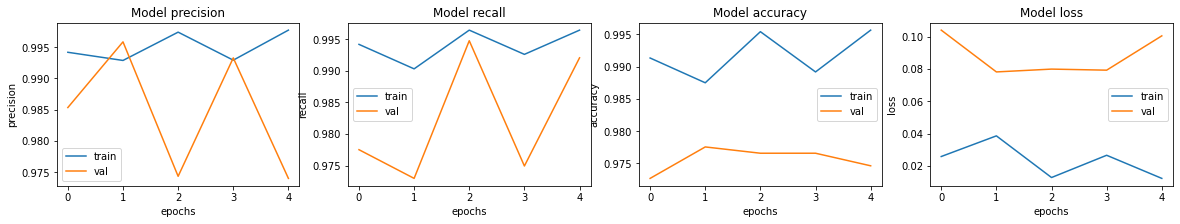

20/20 [==============================] - 4s 203ms/step - loss: 2.3598 - accuracy: 0.6731 - precision: 0.6566 - recall: 1.0000
Loss: 2.359844923019409,
Accuracy: 0.6730769276618958,
Precision: 0.6565656661987305,
Recall: 1.0


In [35]:
EPOCHS = 5
with tf.device('/GPU:0'):
    buf_history = model.fit(
        train_ds_aug_32,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_32,
        epochs=EPOCHS,
        validation_data=val_ds_aug_32,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_32,
    )
model_.append(model)
history.append(buf_history)   
# 결과 확인
show_result(buf_history, test_ds_32)


Epoch 1/5
130/130 [==============================] - 54s 362ms/step - loss: 0.0157 - accuracy: 0.9947 - precision: 0.9964 - recall: 0.9964 - val_loss: 0.0690 - val_accuracy: 0.9814 - val_precision: 0.9946 - val_recall: 0.9801
Epoch 2/5
130/130 [==============================] - 48s 369ms/step - loss: 0.0067 - accuracy: 0.9981 - precision: 0.9984 - recall: 0.9990 - val_loss: 0.0730 - val_accuracy: 0.9814 - val_precision: 0.9933 - val_recall: 0.9814
Epoch 3/5
130/130 [==============================] - 48s 373ms/step - loss: 0.0167 - accuracy: 0.9942 - precision: 0.9974 - recall: 0.9948 - val_loss: 0.0590 - val_accuracy: 0.9844 - val_precision: 0.9842 - val_recall: 0.9947
Epoch 4/5
130/130 [==============================] - 49s 375ms/step - loss: 0.0192 - accuracy: 0.9933 - precision: 0.9958 - recall: 0.9952 - val_loss: 0.0738 - val_accuracy: 0.9824 - val_precision: 0.9973 - val_recall: 0.9787
Epoch 5/5
130/130 [==============================] - 50s 386ms/step - loss: 0.0087 - accuracy: 0

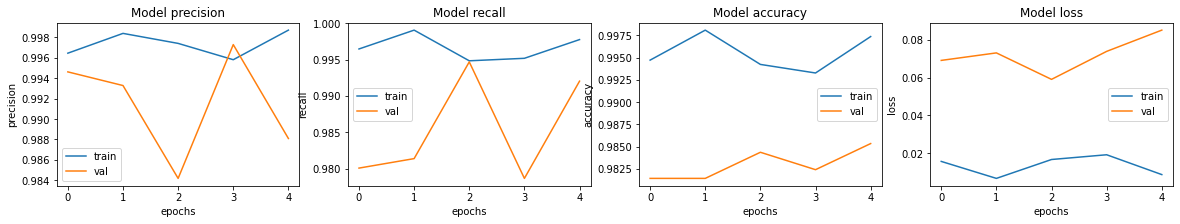

20/20 [==============================] - 4s 197ms/step - loss: 2.1957 - accuracy: 0.7179 - precision: 0.6890 - recall: 1.0000
Loss: 2.195669174194336,
Accuracy: 0.7179487347602844,
Precision: 0.6890459656715393,
Recall: 1.0


In [36]:
EPOCHS = 5
with tf.device('/GPU:0'):
    buf_history = model.fit(
        train_ds_aug_ran_32,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_32,
        epochs=EPOCHS,
        validation_data=val_ds_aug_ran_32,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_32,
    )
model_.append(model)
history.append(buf_history)   
# 결과 확인
show_result(buf_history, test_ds_32)


# test 4 (class_weight)
- epoch : 5
- batch size : 32
- augmentation : O_random
- class_weight : [N(1.95), P(0.67)], [10, 0.1], [1, 10]


- recall의 변화를 보기위해 class_weight를 변경해봄
- normal의 weight를 극단적으로 증가했을때 recall이 떨어지고 accurancy도 떨어짐
- pneumoniad의 weight를 증가했을때 recall이 1에 최대한 가까워지고 accurancy는 떨어짐

In [42]:
# weight는 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


Epoch 1/5
130/130 [==============================] - 57s 373ms/step - loss: 0.0229 - accuracy: 0.9901 - precision: 0.9971 - recall: 0.9897 - val_loss: 0.1073 - val_accuracy: 0.9766 - val_precision: 0.9854 - val_recall: 0.9828
Epoch 2/5
130/130 [==============================] - 47s 367ms/step - loss: 0.0285 - accuracy: 0.9904 - precision: 0.9974 - recall: 0.9897 - val_loss: 0.0822 - val_accuracy: 0.9805 - val_precision: 0.9959 - val_recall: 0.9774
Epoch 3/5
130/130 [==============================] - 48s 370ms/step - loss: 0.0219 - accuracy: 0.9937 - precision: 0.9984 - recall: 0.9932 - val_loss: 0.0477 - val_accuracy: 0.9844 - val_precision: 0.9907 - val_recall: 0.9880
Epoch 4/5
130/130 [==============================] - 49s 376ms/step - loss: 0.0140 - accuracy: 0.9947 - precision: 0.9987 - recall: 0.9942 - val_loss: 0.0603 - val_accuracy: 0.9814 - val_precision: 0.9881 - val_recall: 0.9868
Epoch 5/5
130/130 [==============================] - 50s 386ms/step - loss: 0.0210 - accuracy: 0

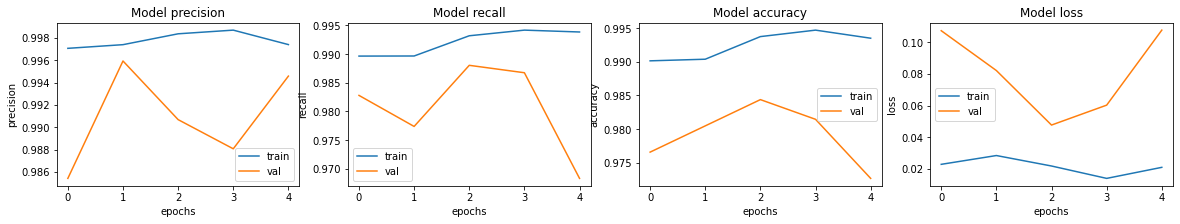

20/20 [==============================] - 4s 202ms/step - loss: 0.9980 - accuracy: 0.8109 - precision: 0.7753 - recall: 0.9821
Loss: 0.9980015754699707,
Accuracy: 0.8108974099159241,
Precision: 0.7753036618232727,
Recall: 0.9820512533187866


In [43]:
EPOCHS = 5
with tf.device('/GPU:0'):
    buf_history = model.fit(
        train_ds_aug_ran_32,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_32,
        epochs=EPOCHS,
        validation_data=val_ds_aug_ran_32,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_32,
        class_weight=class_weight,
    )
model_.append(model)
history.append(buf_history)   
# 결과 확인
show_result(buf_history, test_ds_32)


Epoch 1/5
130/130 [==============================] - 55s 362ms/step - loss: 0.0058 - accuracy: 0.9887 - precision: 1.0000 - recall: 0.9848 - val_loss: 0.1171 - val_accuracy: 0.9717 - val_precision: 0.9959 - val_recall: 0.9655
Epoch 2/5
130/130 [==============================] - 47s 365ms/step - loss: 0.0048 - accuracy: 0.9877 - precision: 1.0000 - recall: 0.9835 - val_loss: 0.1693 - val_accuracy: 0.9629 - val_precision: 0.9972 - val_recall: 0.9520
Epoch 3/5
130/130 [==============================] - 48s 370ms/step - loss: 0.0035 - accuracy: 0.9918 - precision: 1.0000 - recall: 0.9890 - val_loss: 0.1051 - val_accuracy: 0.9766 - val_precision: 0.9959 - val_recall: 0.9722
Epoch 4/5
130/130 [==============================] - 48s 371ms/step - loss: 0.0392 - accuracy: 0.9596 - precision: 0.9986 - recall: 0.9470 - val_loss: 0.7523 - val_accuracy: 0.7637 - val_precision: 0.9980 - val_recall: 0.6795
Epoch 5/5
130/130 [==============================] - 49s 381ms/step - loss: 0.2274 - accuracy: 0

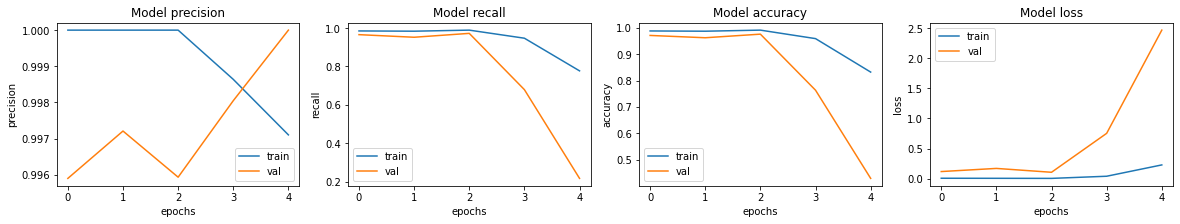

20/20 [==============================] - 4s 203ms/step - loss: 1.7447 - accuracy: 0.5497 - precision: 0.9580 - recall: 0.2923
Loss: 1.7446935176849365,
Accuracy: 0.5496794581413269,
Precision: 0.9579831957817078,
Recall: 0.29230770468711853


In [44]:
class_weight[0] = 10
class_weight[1] = 0.1

EPOCHS = 5
with tf.device('/GPU:0'):
    buf_history = model.fit(
        train_ds_aug_ran_32,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_32,
        epochs=EPOCHS,
        validation_data=val_ds_aug_ran_32,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_32,
        class_weight=class_weight,
    )
model_.append(model)
history.append(buf_history)   
# 결과 확인
show_result(buf_history, test_ds_32)


Epoch 1/5
130/130 [==============================] - 56s 368ms/step - loss: 0.5513 - accuracy: 0.9221 - precision: 0.9174 - recall: 0.9838 - val_loss: 0.0900 - val_accuracy: 0.9658 - val_precision: 0.9629 - val_recall: 0.9921
Epoch 2/5
130/130 [==============================] - 47s 366ms/step - loss: 0.1771 - accuracy: 0.9589 - precision: 0.9499 - recall: 0.9974 - val_loss: 0.1348 - val_accuracy: 0.9531 - val_precision: 0.9400 - val_recall: 1.0000
Epoch 3/5
130/130 [==============================] - 48s 372ms/step - loss: 0.1413 - accuracy: 0.9678 - precision: 0.9608 - recall: 0.9974 - val_loss: 0.0897 - val_accuracy: 0.9707 - val_precision: 0.9641 - val_recall: 0.9974
Epoch 4/5
130/130 [==============================] - 48s 372ms/step - loss: 0.1495 - accuracy: 0.9675 - precision: 0.9611 - recall: 0.9968 - val_loss: 1.7427 - val_accuracy: 0.7305 - val_precision: 0.7398 - val_recall: 0.9802
Epoch 5/5
130/130 [==============================] - 50s 383ms/step - loss: 0.1916 - accuracy: 0

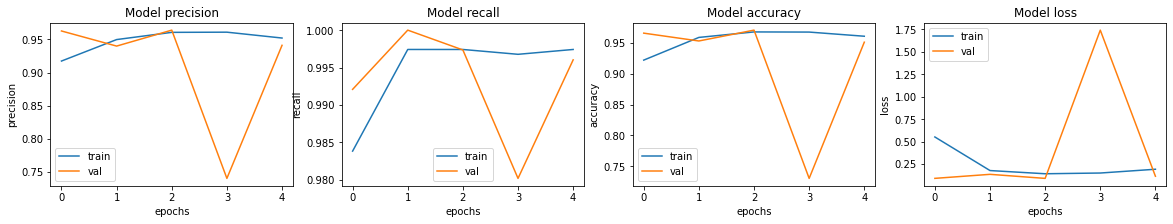

20/20 [==============================] - 4s 199ms/step - loss: 1.6498 - accuracy: 0.6843 - precision: 0.6644 - recall: 1.0000
Loss: 1.6497550010681152,
Accuracy: 0.6842948794364929,
Precision: 0.6643952131271362,
Recall: 1.0


In [45]:
class_weight[0] = 1
class_weight[1] = 10

EPOCHS = 5
with tf.device('/GPU:0'):
    buf_history = model.fit(
        train_ds_aug_ran_32,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_32,
        epochs=EPOCHS,
        validation_data=val_ds_aug_ran_32,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_32,
        class_weight=class_weight,
    )
model_.append(model)
history.append(buf_history)   
# 결과 확인
show_result(buf_history, test_ds_32)


# test 5 (drop out)
- epoch : 5
- batch size : 32
- augmentation : O_random
- class_weight : [N(1.95), P(0.67)]
- drop out : x


In [46]:
# weight는 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [47]:
# conv block
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])    
    return block

# dense block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
    ])
    return block


In [48]:
# model build
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        conv_block(256),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model


with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )


Epoch 1/5
130/130 [==============================] - 57s 371ms/step - loss: 0.2044 - accuracy: 0.9187 - precision: 0.9788 - recall: 0.9105 - val_loss: 0.5833 - val_accuracy: 0.7363 - val_precision: 0.7363 - val_recall: 1.0000
Epoch 2/5
130/130 [==============================] - 48s 367ms/step - loss: 0.1450 - accuracy: 0.9469 - precision: 0.9805 - recall: 0.9472 - val_loss: 0.6960 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 3/5
130/130 [==============================] - 48s 370ms/step - loss: 0.1186 - accuracy: 0.9603 - precision: 0.9870 - recall: 0.9593 - val_loss: 1.0263 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 4/5
130/130 [==============================] - 48s 373ms/step - loss: 0.0996 - accuracy: 0.9599 - precision: 0.9874 - recall: 0.9585 - val_loss: 1.6426 - val_accuracy: 0.7314 - val_precision: 0.7314 - val_recall: 1.0000
Epoch 5/5
130/130 [==============================] - 50s 385ms/step - loss: 0.1067 - accuracy: 0

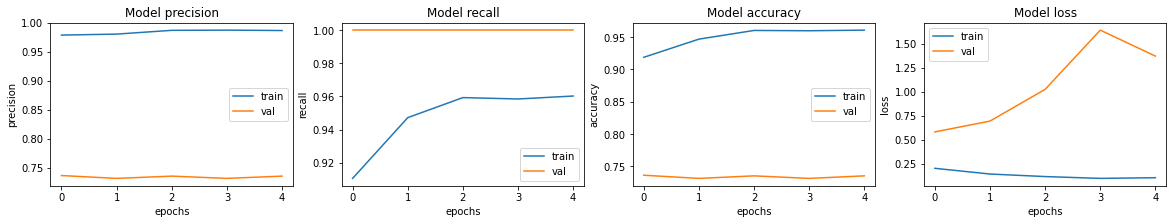

20/20 [==============================] - 4s 215ms/step - loss: 2.2210 - accuracy: 0.6250 - precision: 0.6250 - recall: 1.0000
Loss: 2.2209930419921875,
Accuracy: 0.625,
Precision: 0.625,
Recall: 1.0


In [49]:
EPOCHS = 5
with tf.device('/GPU:0'):
    buf_history = model.fit(
        train_ds_aug_ran_32,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_32,
        epochs=EPOCHS,
        validation_data=val_ds_aug_ran_32,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_32,
        class_weight=class_weight,
    )
model_.append(model)
history.append(buf_history)   
# 결과 확인
show_result(buf_history, test_ds_32)


# test 6 (최종)
- epoch : 5
- batch size : 32
- augmentation : O_random
- class_weight : [N(1.95), P(0.67)]
- drop out : o


In [27]:
# weight는 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


In [28]:
# conv block
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])    
    return block

# dense block
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block


In [29]:
# model build
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )


Epoch 1/5
130/130 [==============================] - 56s 371ms/step - loss: 0.1471 - accuracy: 0.9423 - precision: 0.9808 - recall: 0.9408 - val_loss: 0.2906 - val_accuracy: 0.8691 - val_precision: 0.8503 - val_recall: 1.0000
Epoch 2/5
130/130 [==============================] - 48s 369ms/step - loss: 0.1333 - accuracy: 0.9505 - precision: 0.9830 - recall: 0.9500 - val_loss: 0.1081 - val_accuracy: 0.9580 - val_precision: 0.9472 - val_recall: 0.9987
Epoch 3/5
130/130 [==============================] - 47s 359ms/step - loss: 0.1253 - accuracy: 0.9529 - precision: 0.9846 - recall: 0.9514 - val_loss: 0.1082 - val_accuracy: 0.9629 - val_precision: 0.9972 - val_recall: 0.9520
Epoch 4/5
130/130 [==============================] - 48s 370ms/step - loss: 0.1158 - accuracy: 0.9548 - precision: 0.9856 - recall: 0.9532 - val_loss: 0.4430 - val_accuracy: 0.8564 - val_precision: 1.0000 - val_recall: 0.8058
Epoch 5/5
130/130 [==============================] - 50s 385ms/step - loss: 0.1271 - accuracy: 0

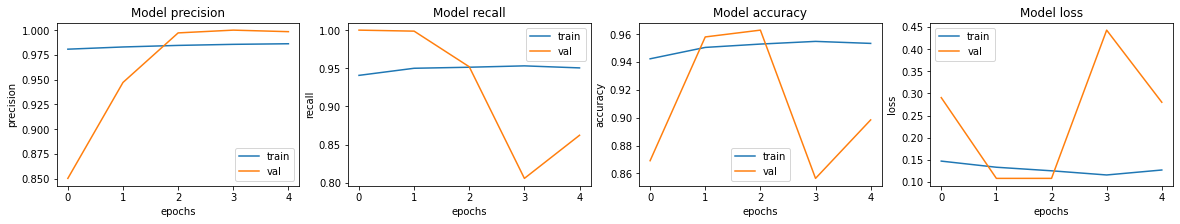

20/20 [==============================] - 4s 196ms/step - loss: 0.3554 - accuracy: 0.8670 - precision: 0.8886 - recall: 0.9000
Loss: 0.355433851480484,
Accuracy: 0.8669871687889099,
Precision: 0.8886076211929321,
Recall: 0.8999999761581421


In [31]:
EPOCHS = 5
with tf.device('/GPU:0'):
    buf_history = model.fit(
        train_ds_aug_32,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE_32,
        epochs=EPOCHS,
        validation_data=val_ds_aug_32,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE_32,
        class_weight=class_weight,
    )
model_.append(model)
history.append(buf_history)   
# 결과 확인
show_result(buf_history, test_ds_32)


## Accuracy: 0.8669871687889099